In [1]:
from datetime import datetime
import psycopg2
import random
import pandas as pd
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load environment variables



In [3]:
load_dotenv()

True

In [4]:
# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname=os.getenv("DB_DATABASE_NAME"),
    user=os.getenv("DB_USERNAME"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"), 
    port=os.getenv("DB_PORT")
)

cursor = conn.cursor()

In [5]:
cursor.execute(
""" SELECT 
    u.username, 
    g.title, 
    g.release_date, 
    g.rating, 
    g.reviews, 
    o.payment_method, 
    ot.unit_price, 
    ot.discount, 
    ot.quantity,
	o.created_at,
    ARRAY_AGG(DISTINCT c.name) AS genres
FROM "Users" u
JOIN "Orders" o ON u.user_id = o.user_id
JOIN "OrderItems" ot ON o.order_id = ot.order_id
JOIN "Games" g ON ot.game_id = g.game_id
JOIN "GameCategories" gc ON g.game_id = gc.game_id
JOIN "Categories" c ON gc.category_id = c.category_id
GROUP BY u.username, g.title, g.release_date, g.rating, g.reviews, o.payment_method, ot.unit_price, ot.discount, ot.quantity, o.created_at;
""")

sales_data = cursor.fetchall()

In [6]:
print(len(sales_data))

505466


In [8]:
columns = [desc[0] for desc in cursor.description]
columns

['username',
 'title',
 'release_date',
 'rating',
 'reviews',
 'payment_method',
 'unit_price',
 'discount',
 'quantity',
 'created_at',
 'genres']

In [9]:
df_sales = pd.DataFrame(sales_data, columns=columns)

In [10]:
df_sales.rename(columns={
    'username': 'user_name',
    'title': 'game_title',
    'release_date': 'release_date',
    'rating': 'game_rating',
    'reviews': 'game_review',
    'payment_method': 'payment_type',
    'unit_price': 'unit_price',
    'discount': 'discount_rate',
    'quantity': 'quantity',
    'created_at': 'purchase_date',
    'genres': 'game_genres'
}, inplace=True)

In [11]:
df_sales.head()

,user_name,game_title,release_date,game_rating,game_review,payment_type,unit_price,discount_rate,quantity,purchase_date,game_genres
0,aacevedo20829a,Rocket Science Adventures,2024-01-10,4.0,Overwhelmingly Positive,CREDIT_CARD,12.00,0.00,1,2024-11-07 00:00:00-05:00,"[Adventure, RPG, Sandbox, Simulation, Strategy]"
1,aadams3215,Rocket Science Adventures,2024-01-10,4.0,Overwhelmingly Positive,CREDIT_CARD,12.00,0.00,1,2024-03-08 00:00:00-05:00,"[Adventure, RPG, Sandbox, Simulation, Strategy]"
2,aadams3215,Shadowstrike Royale,2024-05-05,4.5,Very Positive,CREDIT_CARD,20.00,0.00,1,2024-06-24 00:00:00-04:00,"[Action, Battle Royale, Multiplayer, Open-worl..."
3,aadams36169a,Rocket Science Adventures,2024-01-10,4.0,Overwhelmingly Positive,CREDIT_CARD,12.00,0.00,1,2025-01-06 00:00:00-05:00,"[Adventure, RPG, Sandbox, Simulation, Strategy]"
4,aaguilar5036,Rocket Science Adventures,2024-01-10,4.0,Overwhelmingly Positive,CREDIT_CARD,12.00,0.00,1,2024-03-11 00:00:00-04:00,"[Adventure, RPG, Sandbox, Simulation, Strategy]"


In [12]:
# df_sales['purchase_date'] = df_sales['purchase_date'].dt.tz_localize(None)

df_sales['purchase_date'] = pd.to_datetime(df_sales['purchase_date'], utc=True)
df_sales['release_date'] = pd.to_datetime(df_sales['release_date'])

In [13]:
df_sales['unit_price'] = df_sales['unit_price'].astype(float)
df_sales['discount_rate'] = df_sales['discount_rate'].astype(float)

In [14]:
df_sales.head()

,user_name,game_title,release_date,game_rating,game_review,payment_type,unit_price,discount_rate,quantity,purchase_date,game_genres
0,aacevedo20829a,Rocket Science Adventures,2024-01-10,4.0,Overwhelmingly Positive,CREDIT_CARD,12.0,0.0,1,2024-11-07 05:00:00+00:00,"[Adventure, RPG, Sandbox, Simulation, Strategy]"
1,aadams3215,Rocket Science Adventures,2024-01-10,4.0,Overwhelmingly Positive,CREDIT_CARD,12.0,0.0,1,2024-03-08 05:00:00+00:00,"[Adventure, RPG, Sandbox, Simulation, Strategy]"
2,aadams3215,Shadowstrike Royale,2024-05-05,4.5,Very Positive,CREDIT_CARD,20.0,0.0,1,2024-06-24 04:00:00+00:00,"[Action, Battle Royale, Multiplayer, Open-worl..."
3,aadams36169a,Rocket Science Adventures,2024-01-10,4.0,Overwhelmingly Positive,CREDIT_CARD,12.0,0.0,1,2025-01-06 05:00:00+00:00,"[Adventure, RPG, Sandbox, Simulation, Strategy]"
4,aaguilar5036,Rocket Science Adventures,2024-01-10,4.0,Overwhelmingly Positive,CREDIT_CARD,12.0,0.0,1,2024-03-11 04:00:00+00:00,"[Adventure, RPG, Sandbox, Simulation, Strategy]"


In [15]:
df_sales.dtypes

user_name                     object
game_title                    object
release_date          datetime64[ns]
game_rating                  float64
game_review                   object
payment_type                  object
unit_price                   float64
discount_rate                float64
quantity                       int64
purchase_date    datetime64[ns, UTC]
game_genres                   object
dtype: object

In [16]:
cursor.execute(
""" SELECT name FROM "Categories";
""")

category_names = cursor.fetchall()

In [17]:
categories = [category[0] for category in category_names]

In [18]:
categories

['Action',
 'Adventure',
 'Strategy',
 'FPS',
 'Simulation',
 'Puzzle',
 'Battle Royale',
 'Multiplayer',
 'Survival',
 'Card',
 'RPG',
 'Open-world',
 'Sandbox',
 'MOBA']

In [19]:
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df_sales['game_genres'])

In [20]:
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)
genre_df.head()

,Action,Adventure,Battle Royale,Multiplayer,Open-world,RPG,Sandbox,Simulation,Strategy,Survival
0,0,1,0,0,0,1,1,1,1,0
1,0,1,0,0,0,1,1,1,1,0
2,1,0,1,1,1,0,0,0,0,1
3,0,1,0,0,0,1,1,1,1,0
4,0,1,0,0,0,1,1,1,1,0


In [21]:
df_sales = df_sales.drop(columns=['game_genres']).join(genre_df)

In [22]:
review_mapping = {'Negative': 0, 'Mostly Negative': 1, 'Mixed': 2, 'Somewhat Positive': 3, 'Very Positive': 4, 'Overwhelmingly Positive': 5}

df_sales['game_review_encoded'] = df_sales['game_review'].map(review_mapping)

In [23]:
(df_sales['purchase_date'].dt.date - df_sales['release_date'].dt.date).apply(lambda x: x.days)

0         302
1          58
2          50
3         362
4          61
         ... 
505461    364
505462    320
505463    163
505464    167
505465    214
Length: 505466, dtype: int64

In [24]:
df_sales['days_since_release'] = (df_sales['purchase_date'].dt.date - df_sales['release_date'].dt.date).apply(lambda x: x.days)

In [364]:
df_sales.head()

,user_name,game_title,release_date,game_rating,game_review,payment_type,unit_price,discount_rate,quantity,purchase_date,...,Battle Royale,Multiplayer,Open-world,RPG,Sandbox,Simulation,Strategy,Survival,game_review_encoded,days_since_release
0,aacevedo20829a,Rocket Science Adventures,2024-01-10,4.0,Overwhelmingly Positive,CREDIT_CARD,12.0,0.0,1,2024-11-07 05:00:00+00:00,...,0,0,0,1,1,1,1,0,5,302
1,aadams3215,Rocket Science Adventures,2024-01-10,4.0,Overwhelmingly Positive,CREDIT_CARD,12.0,0.0,1,2024-03-08 05:00:00+00:00,...,0,0,0,1,1,1,1,0,5,58
2,aadams3215,Shadowstrike Royale,2024-05-05,4.5,Very Positive,CREDIT_CARD,20.0,0.0,1,2024-06-24 04:00:00+00:00,...,1,1,1,0,0,0,0,1,4,50
3,aadams36169a,Rocket Science Adventures,2024-01-10,4.0,Overwhelmingly Positive,CREDIT_CARD,12.0,0.0,1,2025-01-06 05:00:00+00:00,...,0,0,0,1,1,1,1,0,5,362
4,aaguilar5036,Rocket Science Adventures,2024-01-10,4.0,Overwhelmingly Positive,CREDIT_CARD,12.0,0.0,1,2024-03-11 04:00:00+00:00,...,0,0,0,1,1,1,1,0,5,61


In [365]:

# Feature engineer launch_boost if the game is bought within 1 week
df_sales['launch_boost'] = (df_sales['days_since_release'] <= 7).astype(int)

In [366]:
df_sales.dtypes

user_name                           object
game_title                          object
release_date                datetime64[ns]
game_rating                        float64
game_review                         object
payment_type                        object
unit_price                         float64
discount_rate                      float64
quantity                             int64
purchase_date          datetime64[ns, UTC]
Action                               int64
Adventure                            int64
Battle Royale                        int64
Multiplayer                          int64
Open-world                           int64
RPG                                  int64
Sandbox                              int64
Simulation                           int64
Strategy                             int64
Survival                             int64
game_review_encoded                  int64
days_since_release                   int64
launch_boost                         int64
dtype: obje

## Model application

In [186]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

In [367]:
df_sales['purchase_date'] = df_sales['purchase_date'].dt.date

In [466]:
df_time_series = df_sales.groupby(['purchase_date', 'game_title'])[["quantity"]].sum().reset_index()
df_time_series = df_time_series[df_time_series['game_title'] == 'Rocket Science Adventures']

In [467]:
df_time_series['purchase_date'] = pd.to_datetime(df_time_series['purchase_date'])

In [489]:
df_sales['purchase_date'] = pd.to_datetime(df_sales['purchase_date'], errors='coerce')

# Now group by 'purchase_date' and 'game_title' to sum 'quantity'
df_time_series = df_sales.groupby(['purchase_date', 'game_title'])[["quantity"]].sum().reset_index()

# Filter for the specific game title (e.g., 'Rocket Science Adventures')
df_time_series = df_time_series[df_time_series['game_title'] == 'Rocket Science Adventures']

# Select the remaining columns and drop duplicates (no aggregation needed here)
df_remaining_columns = df_sales[['purchase_date', 'game_title','game_rating', 'unit_price', 'discount_rate', 'game_review_encoded', 'launch_boost', 'days_since_release']].drop_duplicates()

# Merge the time series data with the remaining columns from the original data
df_time_series = pd.merge(df_time_series, df_remaining_columns, on=['purchase_date', 'game_title'], how='left')

# Check the resulting DataFrame
print(df_time_series.head())

  purchase_date                 game_title  quantity  game_rating  unit_price  \
0    2024-01-10  Rocket Science Adventures         5          4.0        12.0   
1    2024-01-11  Rocket Science Adventures        19          4.0        12.0   
2    2024-01-12  Rocket Science Adventures        29          4.0        12.0   
3    2024-01-13  Rocket Science Adventures        48          4.0        12.0   
4    2024-01-14  Rocket Science Adventures        43          4.0        12.0   

   discount_rate  game_review_encoded  launch_boost  days_since_release  
0            0.0                    5             1                   0  
1            0.0                    5             1                   1  
2            0.0                    5             1                   2  
3            0.0                    5             1                   3  
4            0.0                    5             1                   4  


In [490]:
df_time_series.head()

,purchase_date,game_title,quantity,game_rating,unit_price,discount_rate,game_review_encoded,launch_boost,days_since_release
0,2024-01-10,Rocket Science Adventures,5,4.0,12.0,0.0,5,1,0
1,2024-01-11,Rocket Science Adventures,19,4.0,12.0,0.0,5,1,1
2,2024-01-12,Rocket Science Adventures,29,4.0,12.0,0.0,5,1,2
3,2024-01-13,Rocket Science Adventures,48,4.0,12.0,0.0,5,1,3
4,2024-01-14,Rocket Science Adventures,43,4.0,12.0,0.0,5,1,4


In [491]:
print(len(df_time_series))

386


In [372]:
# df_time_series['year'] = df_time_series['purchase_date'].dt.year
# df_time_series['month'] = df_time_series['purchase_date'].dt.month
# df_time_series['day'] = df_time_series['purchase_date'].dt.day
# df_time_series['day_of_week'] = df_time_series['purchase_date'].dt.weekday
# df_time_series['week_of_year'] = df_time_series['purchase_date'].dt.isocalendar().week

In [373]:
# df_time_series = df_time_series.merge(df_sales[['game_title'] + ['game_rating', 'game_review_encoded', 'discount_rate',
#                           'unit_price', 'launch_boost', 'Action', 'Adventure', 'Battle Royale', 'Multiplayer', 
#      'Open-world', 'RPG', 'Sandbox', 'Simulation', 'Strategy', 'Survival', 'days_since_release']].drop_duplicates(),
#     on='game_title', how='left')

In [477]:
df_remaining_columns = df_sales[['purchase_date', 'game_title', 'game_rating', 'unit_price', 'discount_rate', 'game_review_encoded', 'launch_boost', 'days_since_release']].drop_duplicates()

In [478]:
df_merged = pd.merge(df_time_series, df_remaining_columns, on=['purchase_date', 'game_title'], how='left')

ValueError: You are trying to merge on datetime64[ns] and object columns for key 'purchase_date'. If you wish to proceed you should use pd.concat

In [492]:
df_time_series.head()

,purchase_date,game_title,quantity,game_rating,unit_price,discount_rate,game_review_encoded,launch_boost,days_since_release
0,2024-01-10,Rocket Science Adventures,5,4.0,12.0,0.0,5,1,0
1,2024-01-11,Rocket Science Adventures,19,4.0,12.0,0.0,5,1,1
2,2024-01-12,Rocket Science Adventures,29,4.0,12.0,0.0,5,1,2
3,2024-01-13,Rocket Science Adventures,48,4.0,12.0,0.0,5,1,3
4,2024-01-14,Rocket Science Adventures,43,4.0,12.0,0.0,5,1,4


In [493]:
df_time_series.dtypes

purchase_date          datetime64[ns]
game_title                     object
quantity                        int64
game_rating                   float64
unit_price                    float64
discount_rate                 float64
game_review_encoded             int64
launch_boost                    int64
days_since_release              int64
dtype: object

In [494]:
df_time_series.fillna(0, inplace=True)

# Display the final time series dataset
print(df_time_series.head())

  purchase_date                 game_title  quantity  game_rating  unit_price  \
0    2024-01-10  Rocket Science Adventures         5          4.0        12.0   
1    2024-01-11  Rocket Science Adventures        19          4.0        12.0   
2    2024-01-12  Rocket Science Adventures        29          4.0        12.0   
3    2024-01-13  Rocket Science Adventures        48          4.0        12.0   
4    2024-01-14  Rocket Science Adventures        43          4.0        12.0   

   discount_rate  game_review_encoded  launch_boost  days_since_release  
0            0.0                    5             1                   0  
1            0.0                    5             1                   1  
2            0.0                    5             1                   2  
3            0.0                    5             1                   3  
4            0.0                    5             1                   4  


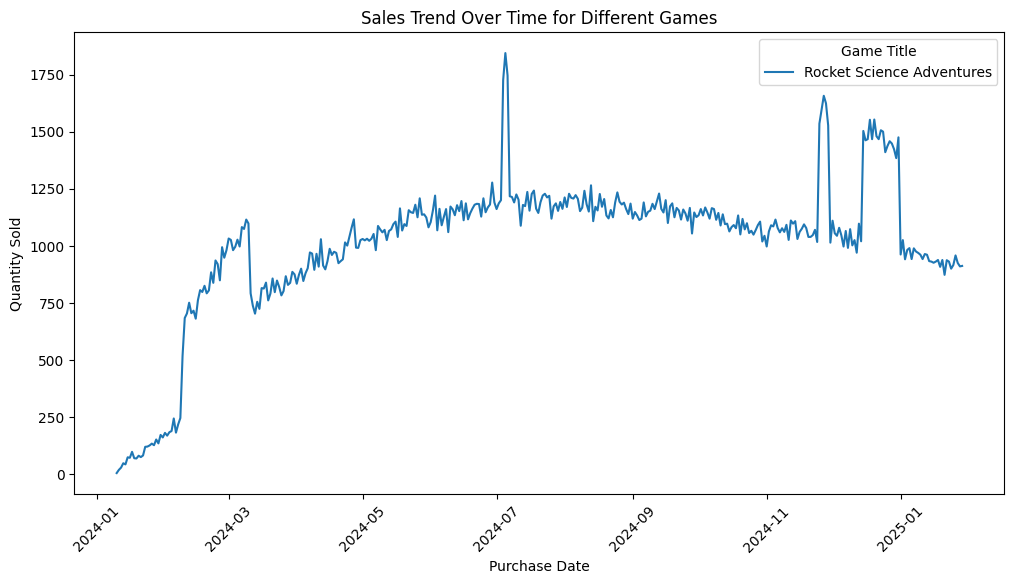

In [495]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the date is sorted
df_time_series = df_time_series.sort_values(by=['purchase_date'])

# Set figure size
plt.figure(figsize=(12, 6))

# Plot for each game
sns.lineplot(data=df_time_series, x='purchase_date', y='quantity', hue='game_title')

# Labels and title
plt.xlabel('Purchase Date')
plt.ylabel('Quantity Sold')
plt.title('Sales Trend Over Time for Different Games')
plt.xticks(rotation=45)
plt.legend(title="Game Title")

# Show plot
plt.show()

In [421]:
features = [
 'quantity',
 'game_rating',
 'game_review_encoded',
 'unit_price',
 'discount_rate']

In [453]:
len(df_time_series)

148989

In [496]:
def create_lags(df, lags=7):
    for lag in range(1, lags+1):
        df[f'lag_{lag}'] = df['quantity'].shift(lag)
    return df

In [497]:
df_time_series = create_lags(df_time_series, lags=7)

In [498]:
df_time_series.dtypes

purchase_date          datetime64[ns]
game_title                     object
quantity                        int64
game_rating                   float64
unit_price                    float64
discount_rate                 float64
game_review_encoded             int64
launch_boost                    int64
days_since_release              int64
lag_1                         float64
lag_2                         float64
lag_3                         float64
lag_4                         float64
lag_5                         float64
lag_6                         float64
lag_7                         float64
dtype: object

In [499]:
df_time_series.head(50)

,purchase_date,game_title,quantity,game_rating,unit_price,discount_rate,game_review_encoded,launch_boost,days_since_release,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,2024-01-10,Rocket Science Adventures,5,4.0,12.0,0.0,5,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-11,Rocket Science Adventures,19,4.0,12.0,0.0,5,1,1,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-12,Rocket Science Adventures,29,4.0,12.0,0.0,5,1,2,19.0,5.0,NaN,NaN,NaN,NaN,NaN
3,2024-01-13,Rocket Science Adventures,48,4.0,12.0,0.0,5,1,3,29.0,19.0,5.0,NaN,NaN,NaN,NaN
4,2024-01-14,Rocket Science Adventures,43,4.0,12.0,0.0,5,1,4,48.0,29.0,19.0,5.0,NaN,NaN,NaN
5,2024-01-15,Rocket Science Adventures,74,4.0,12.0,0.0,5,1,5,43.0,48.0,29.0,19.0,5.0,NaN,NaN
6,2024-01-16,Rocket Science Adventures,72,4.0,12.0,0.0,5,1,6,74.0,43.0,48.0,29.0,19.0,5.0,NaN
7,2024-01-17,Rocket Science Adventures,98,4.0,12.0,0.0,5,1,7,72.0,74.0,43.0,48.0,29.0,19.0,5.0
8,2024-01-18,Rocket Science Adventures,70,4.0,12.0,0.0,5,0,8,98.0,72.0,74.0,43.0,48.0,29.0,19.0
9,2024-01-19,Rocket Science Adventures,69,4.0,12.0,0.0,5,0,9,70.0,98.0,72.0,74.0,43.0,48.0,29.0


In [ ]:
df_time_series.head()

In [295]:
# df_time_series['month_sin'] = np.sin(2 * np.pi * df_time_series['month'] / 12)
# df_time_series['month_cos'] = np.cos(2 * np.pi * df_time_series['month'] / 12)
# df_time_series['day_of_week_sin'] = np.sin(2 * np.pi * df_time_series['day_of_week'] / 7)
# df_time_series['day_of_week_cos'] = np.cos(2 * np.pi * df_time_series['day_of_week'] / 7)
# df_time_series = df_time_series.drop(columns=['month', 'day_of_week'])


In [383]:
# scaler = MinMaxScaler()
# df_time_series[['unit_price', 'discount_rate']] = scaler.fit_transform(df_time_series[['week_of_year', 'unit_price', 'discount_rate']])

In [427]:
print(df_time_series.columns)
print(len(df_time_series.columns))
print(df_time_series.dtypes)
for i in df_time_series.dtypes:
    print(i)

Index(['purchase_date', 'game_title', 'quantity', 'game_rating',
       'game_review_encoded', 'discount_rate', 'unit_price', 'launch_boost',
       'days_since_release', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7'],
      dtype='object')
16
purchase_date          datetime64[ns]
game_title                     object
quantity                        int64
game_rating                   float64
game_review_encoded             int64
discount_rate                 float64
unit_price                    float64
launch_boost                    int64
days_since_release              int64
lag_1                         float64
lag_2                         float64
lag_3                         float64
lag_4                         float64
lag_5                         float64
lag_6                         float64
lag_7                         float64
dtype: object
datetime64[ns]
object
int64
float64
int64
float64
float64
int64
int64
float64
float64
float64
float64
float64
f

In [503]:
df_time_series.dropna(inplace=True)

In [542]:
def create_sequences(X, y, seq_length=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    
    return np.array(X_seq), np.array(y_seq)

seq_length = 7  # You can adjust this depending on your problem

train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series[:train_size], df_time_series[train_size:]

from sklearn.preprocessing import MinMaxScaler

n_timesteps = 20

# Initialize scaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train, y_train = train.drop(columns=['quantity', 'purchase_date', 'game_title']), train['quantity']
X_test, y_test = test.drop(columns=['quantity', 'purchase_date', 'game_title']), test['quantity']

# Scale the data (already shown earlier)
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Create sequences for LSTM input
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_timesteps)

# Reshape X to (samples, time steps, features)
X_train_seq = np.reshape(X_train_seq, (X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2]))
X_test_seq = np.reshape(X_test_seq, (X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2]))


In [543]:
model = Sequential([
    # First LSTM layer with return_sequences=True to pass sequences to the next layer
    LSTM(128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    
    # Second LSTM layer
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    
    # Third LSTM layer
    LSTM(128, return_sequences=False),  # No need to return sequences from the last layer
    Dropout(0.2),
    
    # Fully connected Dense layers
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    
    # Output layer (prediction)
    Dense(1)  # Single output for quantity prediction
])

c:\Kushwanth\React\kratos-digital-store\ml\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [544]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=16, validation_data=(X_test_seq, y_test_seq))

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.1465 - val_loss: 0.0191
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0078 - val_loss: 0.0196
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0076 - val_loss: 0.0178
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0080 - val_loss: 0.0174
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0056 - val_loss: 0.0181
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0067 - val_loss: 0.0208
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0049 - val_loss: 0.0188
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0055 - val_loss: 0.0185
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0054 - val_loss: 0.0167
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0044 - val_loss: 0.0189
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0044 - val_loss: 0.0167
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

In [545]:
loss = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0100
Test Loss: 0.008270067162811756


In [546]:
y_pred = model.predict(X_test_seq)

# Print the first 10 predicted values
print(f"Predicted values (first 10): {y_pred[:10].flatten()}")
print(f"Actual values (first 10): {y_test_seq[:10]}")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/stepWARNING:tensorflow:5 out of the last 125 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001C959532440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
Predicted values (first 10): [0.55598724 0.5546844  0.5530265  0.5521305  0.55079544 0.549076
 0.5469825  0.5443542  0.54200345 0.53943497]
Actual values (first 10): [[0.55042254]
 [0.5228169 ]
 

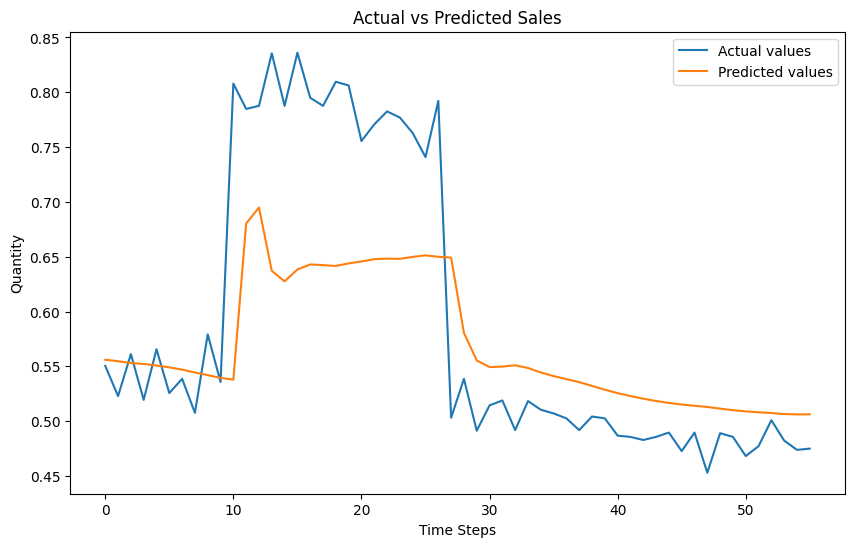

In [547]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_seq, label='Actual values')
plt.plot(y_pred, label='Predicted values')
plt.xlabel('Time Steps')
plt.ylabel('Quantity')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()

In [28]:
# Close database connection
cursor.close()
conn.close()
